<a href="https://colab.research.google.com/github/Agbltnb/Ia/blob/main/ProvaIAQ1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prova 2 Questão 1

**Enunciado da questão:**

Acessar a base de dados HCV(https://archive.ics.uci.edu/ml/datasets/HCV+data#) e desenvolver dois algoritmos supervisionados, podendo ser Redes Neurais Artificiais, Árvore de Decisão ou outros de sua escolha, para classificação entre Doador ou Não Doador, que são positivos para Hepatite C, Fibrose ou Cirrose. Ambos modelos devem ser analisados pelas métricas: Acurácia, Especificidade, Sensibilidade e Matriz de Confusão e os resultados devem ser discutidos. Na base consta instâncias rotuladas como Possíveis Doadores (0s=suspect Blood Donor), que devem ser classificadas separadamente após a construção dos modelos, compare os resultados obtidos em cada método utilizado.

Importando as biblitecas necessárias para a solução desta questão.

In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler


**Carregando o dataset**

In [169]:
df = pd.read_csv('hcvdat0.csv')

print(df.shape)
df.head(4)

(615, 14)


,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7


**Preprocessar os dados**
Será necessário remover a primeira coluna.

In [170]:
df.drop(columns='Unnamed: 0', inplace=True)

Verificação se existe valores faltantes:

In [171]:
print('Valores faltantes:', df.isnull().sum()) #quantidade de valores faltantes para todos os atributos

Valores faltantes: Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64


Como anteriormente podemos perceber que existe valores faltantes, devemos retirar eles.

In [172]:
df = df.dropna()

In [173]:
#vou verificar novamente se existe dados faltantes
#print('Valores faltantes:', df.isnull().sum()) #quantidade de valores faltantes para todos os atributos
np.where(pd.isnull(df))

(array([], dtype=int64), array([], dtype=int64))

No atributo categoria, tem as seguintes labels, ou você é doador(0), hepapitis(1), fibrosis(2), cirosis(3). Logo precisamos unificar as labels acima, exceto o do doador.
E também será necessario colocar o sexo como valores quantitativos já que estão qualitativos.

In [174]:
df['Category'] = df['Category'].replace(['0=Blood Donor', '1=Hepatitis', '2=Fibrosis', '3=Cirrhosis'],[1, 0, 0, 0])
df['Sex'] = df['Sex'].replace(['m', 'f'],[0, 1])
df

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,1,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,1,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,1,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,1,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,0,58,1,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
609,0,59,1,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
610,0,62,1,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,0,64,1,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3


Normalizar os dados.

In [194]:
scaled_features = df.copy()

colunas = ['Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']
features = scaled_features[colunas]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

df[colunas] = features
#df

Em seguida devemos separar quem são os possiveis doares.

In [195]:
possible_donors = df[df.Category == '0s=suspect Blood Donor']
possible_donors = possible_donors.drop(['Category'], axis = 1)
print(possible_donors)
possible_donors

Empty DataFrame
Columns: [Age, Sex, ALB, ALP, ALT, AST, BIL, CHE, CHOL, CREA, GGT, PROT]
Index: []


,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT


In [196]:

df = df.drop(df[df.Category == '0s=suspect Blood Donor'].index)
#df

1    526
0     56
Name: Category, dtype: int64

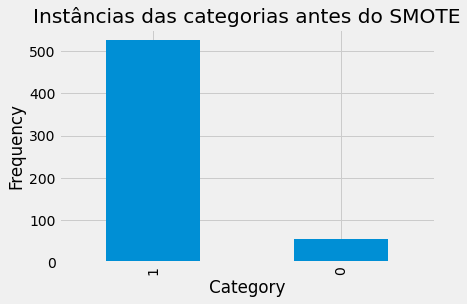

In [197]:
#A partir destes códigos conseguiremos saber quantos doadores tem no 
#atributo de category
#e assim saberemos se são balenceados ou não.
plt.style.use('fivethirtyeight')
pd.value_counts(df['Category']).plot.bar()
plt.title('Instâncias das categorias antes do SMOTE')
plt.xlabel('Category')
plt.ylabel('Frequency')
df['Category'].value_counts()

Em seguida, deveremos separar os dados, do atributo de categoria, para separar quem é doador e quem não é.

In [198]:
categoria = df.Category
variaveis = df.drop('Category', axis=1)

print('Forma de variaveis: {}'.format(variaveis.shape))
print('Forma de categoria: {}'.format(categoria.shape))

Forma de variaveis: (582, 12)
Forma de categoria: (582,)


In [199]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
print('Quantidade do label "1" antes do OverSampling: {}'.format(sum(categoria==1)))
print(' Quantidade do label "" antes do OverSampling:{} \n'.format(sum(categoria==0)))

sm = SMOTE(random_state=1234)
X, y = sm.fit_sample(variaveis.astype('float'), categoria)

print('Depois X : {}'.format(X.shape))
print('Depois  y: {} \n'.format(y.shape))

print('Quantidade do label "1" adepois do OverSampling: {}'.format(sum(y==1)))
print('Quantidade do label "0" adepois do OverSampling:: {}'.format(sum(y==0)))




label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

Quantidade do label "1" antes do OverSampling: 526
 Quantidade do label "" antes do OverSampling:56 

Depois X : (1052, 12)
Depois  y: (1052,) 

Quantidade do label "1" adepois do OverSampling: 526
Quantidade do label "0" adepois do OverSampling:: 526


/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:93: UserWarning:

'y' should be of types ('binary', 'multiclass', 'multilabel-indicator') only. Got unknown instead.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



array([1, 1, 1, ..., 0, 0, 0])

Agora novamente, será necessário a visualização para verificar se agora está balanceado.

1    526
0    526
dtype: int64

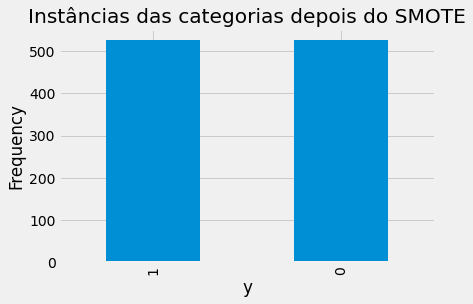

In [200]:
plt.style.use('fivethirtyeight')
pd.value_counts(y).plot.bar()
plt.title('Instâncias das categorias depois do SMOTE')
plt.xlabel('y')
plt.ylabel('Frequency')
pd.value_counts(y)

Após o pre-processamento da base de dados, poderemos separá o treinamento do teste, para a utilizar com o random Forest para o problema de classificação

In [201]:
#primeiro vamos ajustar os dados do treino e dos testes
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1234)

# Random Forest

In [202]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
model = RandomForestClassifier(n_estimators = 10, random_state = 1234)

model.fit(X_train, y_train)

predict_test = model.predict(X_test)


In [203]:
print('Accuracy = ', metrics.accuracy_score(y_test, predict_test))
matrizConfusao = metrics.confusion_matrix(y_test, predict_test)
print("Matriz de Confusão:\n",matrizConfusao)

Accuracy =  0.9968354430379747
Matriz de Confusão:
 [[151   0]
 [  1 164]]


# Knn

In [204]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Treinamento

In [205]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5, metric='euclidean')   #para mudar o valor de k, é só mudar no n_neighbors
classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [206]:
y_pred = classifier.predict(X_test)
print('Predição\n', y_pred)
print('Teste\n', y_test)

Predição
 [0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1
 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0
 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1
 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1
 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 1 1 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0 0
 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1]
Teste
 [0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0
 1 1 1 1 0 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1
 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0
 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0
 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 

In [209]:

from sklearn.metrics import classification_report, confusion_matrix
print('Matriz de Confusão:\n',confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Matriz de Confusão:
 [[151   0]
 [  3 162]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       151
           1       1.00      0.98      0.99       165

    accuracy                           0.99       316
   macro avg       0.99      0.99      0.99       316
weighted avg       0.99      0.99      0.99       316

